<h1>DCGAN Example with MNIST Dataset</h1>

In [1]:
import tempfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
from matplotlib import pyplot as plt
import fastestimator as fe
from fastestimator.backend import binary_crossentropy, feed_forward
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop import NumpyOp
from fastestimator.op.numpyop.univariate import ExpandDims, Normalize
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import ModelSaver

In [2]:
batch_size = 256
epochs = 50
steps_per_epoch = None
validation_steps = None
save_dir = tempfile.mkdtemp()

<h2>Building components</h2>

<h3>Step 1: Prepare training and define pipeline</h3>

We are loading data from tf.keras.datasets.mnist and defining series of operations to perform on the data before the training

In [3]:
train_data, _ = mnist.load_data()
pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x"),
        Normalize(inputs="x", outputs="x", mean=1.0, std=1.0, max_pixel_value=127.5),
        NumpyOp(inputs=lambda: np.random.normal(size=[100]).astype('float32'), outputs="z")
    ])

<h3>Step 2: Create model and FastEstimator network</h3>

First, we have to define the network architecture for both <b>Generator</b> and <b>Discriminator</b>. After defining the architecture, users are expected to feed the architecture definition, its associated model name and optimizer to fe.build.

In [4]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [5]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
gen_model = fe.build(model_fn=generator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))
disc_model = fe.build(model_fn=discriminator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

We define the generator and discriminator loss. Loss can have multiple inputs and outputs.

In [7]:
class GLoss(TensorOp):
    """Compute generator loss."""
    def forward(self, data, state):
        return binary_crossentropy(y_pred=data, y_true=tf.ones_like(data), from_logits=True)

In [8]:
class DLoss(TensorOp):
    """Compute discriminator loss."""
    def forward(self, data, state):
        true_score, fake_score = data
        real_loss = binary_crossentropy(y_pred=true_score, y_true=tf.ones_like(true_score), from_logits=True)
        fake_loss = binary_crossentropy(y_pred=fake_score, y_true=tf.zeros_like(fake_score), from_logits=True)
        total_loss = real_loss + fake_loss
        return total_loss

Here, <i>fe.Network</i> takes series of operators and here we feed our model in the ModelOp with inputs and outputs. Also, group our model with the loss functions that we defined earlier

In [9]:
network = fe.Network(ops=[
        ModelOp(model=gen_model, inputs="z", outputs="x_fake"),
        ModelOp(model=disc_model, inputs="x_fake", outputs="fake_score"),
        GLoss(inputs="fake_score", outputs="gloss"),
        UpdateOp(model=gen_model, loss_name="gloss"),
        ModelOp(inputs="x", model=disc_model, outputs="true_score"),
        DLoss(inputs=("true_score", "fake_score"), outputs="dloss"),
        UpdateOp(model=disc_model, loss_name="dloss")
    ])

<h3>Step 3: Prepare estimator and configure the training loop</h3>

We will define Estimator that has four arguments network, pipeline, epochs and traces. Network and Pipeline objects are passed here as an argument along with number of epochs and traces.

We will define traces to save the model with frequency of five that mean it will save the model at every 5 epochs.

In [10]:
traces=ModelSaver(model=gen_model, save_dir=save_dir, frequency=5)

In [11]:
estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces)

<h2>Training</h2>

In [12]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 1e-04; model1_lr: 1e-04; 
FastEstimator-Train: step: 1; gloss: 0.7122225; dloss: 1.3922014; 
FastEstimator-Train: step: 100; gloss: 0.906471; dloss: 0.8187004; steps/sec: 10.09; 
FastEstimator-Train: step: 200; gloss: 0.59155834; dloss: 1.5896755; steps/sec: 9.93; 
FastEstimator-Train: step: 235; epoch: 1; epoch_time: 28.53 sec; 
FastEstimator-Train: step: 300; gloss: 0.7163421; dloss: 1.3333399; steps/sec: 8.9; 
FastEstimator-Train: step: 400; gloss: 0.6816584; dloss: 1.6007018; steps/sec: 9.88; 
FastEstimator-Trai

FastEstimator-Train: step: 6580; epoch: 28; epoch_time: 24.32 sec; 
FastEstimator-Train: step: 6600; gloss: 1.1773547; dloss: 1.1330662; steps/sec: 9.58; 
FastEstimator-Train: step: 6700; gloss: 1.246088; dloss: 0.8964198; steps/sec: 9.73; 
FastEstimator-Train: step: 6800; gloss: 1.2250234; dloss: 1.0358574; steps/sec: 9.73; 
FastEstimator-Train: step: 6815; epoch: 29; epoch_time: 24.3 sec; 
FastEstimator-Train: step: 6900; gloss: 1.1256618; dloss: 1.196687; steps/sec: 9.59; 
FastEstimator-Train: step: 7000; gloss: 1.1131527; dloss: 1.0596428; steps/sec: 9.73; 
Saved model to /tmp/tmpspul4xo8/model_epoch_30.h5
FastEstimator-Train: step: 7050; epoch: 30; epoch_time: 24.31 sec; 
FastEstimator-Train: step: 7100; gloss: 1.1662202; dloss: 1.0555116; steps/sec: 9.57; 
FastEstimator-Train: step: 7200; gloss: 1.0653521; dloss: 1.1444951; steps/sec: 9.71; 
FastEstimator-Train: step: 7285; epoch: 31; epoch_time: 24.36 sec; 
FastEstimator-Train: step: 7300; gloss: 1.1732882; dloss: 1.1456137; ste

<h2>Inferencing</h2>

For inferencing, first we have to load the trained model weights. We will load the trained generator weights using <i>fe.build</i>

In [19]:
model_name = 'model_epoch_50.h5'
model_path = os.path.join(save_dir, model_name)
trained_model = fe.build(model_fn=generator, weights_path=model_path, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

Loaded model weights from /tmp/tmpspul4xo8/model_epoch_50.h5


We will generate the images from the random noise.

In [20]:
images = feed_forward(trained_model, np.random.normal(size=(16, 100)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



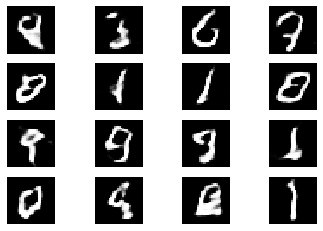

In [21]:
fig, axes = plt.subplots(4, 4)
axes = np.ravel(axes)
for i in range(images.shape[0]):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(images[i, ...] * 127.5 + 127.5), cmap='gray')